## Setup

### Import Libraries

In [ ]:
# ============================================================
# IMPORT LIBRARIES
# ============================================================

# Standard library imports
import sys
import os
import warnings
warnings.filterwarnings('ignore')

# Set working directory to solution folder
solution_dir = r"../solution"
os.chdir(solution_dir)
print(f"📍 Working directory set to: {os.getcwd()}")

📍 Working directory set to: e:\UV\myproject\AssignmentBIGLanguage\solution


In [4]:


# Import configuration
from config import validate_config, USE_MULTI_EMBEDDING

# Import RAG system modules
from rag_system.pdf_loader import load_pdfs, get_document_stats
from rag_system.chunking import chunk_documents, get_chunk_stats
from rag_system.retriever import SimpleRetriever
from rag_system.multi_retriever import MultiEmbeddingRetriever

# Import agents
from agents.rag_agent import RAGAgent
from agents.api_agent import APIAgent
from agents.query_decomposer import QueryDecomposer

# Import LangGraph system
from lang_graph_qa import LangGraphFinancialQA

print("\n✅ All modules imported successfully!")



✅ All modules imported successfully!


### Validate Configuration

In [5]:
# Check if API keys are configured
config_valid = validate_config()

if not config_valid:
    print("\n⚠️ Please set your API keys in the .env file before continuing!")
    print("   1. Copy .env.template to .env")
    print("   2. Add your GROQ_API_KEY from https://console.groq.com/")
    print("   3. Add your RAPIDAPI_KEY from https://rapidapi.com/")

✅ Configuration loaded successfully!


## Problem 1: RAG with Company/Year Isolation

Build a retrieval system that ensures queries for specific companies and years only search the relevant filings.

### Step 1: Load PDF Documents

In [6]:
# Load all 10-K PDF files
# Note: Assignment folder is a sibling to solution, not inside it
print("📄 Loading 10-K PDF files...\n")
pdf_path = os.path.join(os.path.dirname(os.getcwd()), "Assignment", "10-k_docs")
documents = load_pdfs(pdf_path)

# Show statistics
stats = get_document_stats(documents)
print("\n📊 Document Statistics:")
print(f"Total pages: {stats['total_pages']}")
print(f"Companies: {stats['companies']}")
print(f"Years: {stats['years']}")
print("\nPages by company and year:")
for company in stats['by_company']:
    print(f"\n{company}:")
    for year, count in stats['by_company'][company].items():
        print(f"  {year}: {count} pages")

📄 Loading 10-K PDF files...

📄 Loading PDF files...

  Processing AMZN...


  AMZN PDFs: 100%|██████████| 3/3 [00:16<00:00,  5.43s/it]



  Processing UBER...


  UBER PDFs: 100%|██████████| 3/3 [00:43<00:00, 14.33s/it]


✅ Loaded 1069 pages from 6 PDF files

📊 Document Statistics:
Total pages: 1069
Companies: ['AMZN', 'UBER']
Years: [2020, 2021, 2022]

Pages by company and year:

AMZN:
  2020: 102 pages
  2021: 100 pages
  2022: 96 pages

UBER:
  2020: 239 pages
  2021: 272 pages
  2022: 260 pages


In [26]:
# documents[0]['text'][:500]  # Display first 500 characters of the first document

### Step 2: Chunk Documents

In [28]:
# Split documents into chunks for better retrieval
print("\n✂️ Chunking documents...\n")
chunks = chunk_documents(documents, chunk_size=1000, overlap=300)

# Show chunk statistics
chunk_stats = get_chunk_stats(chunks)
print("\n📊 Chunk Statistics:")
print(f"Total chunks: {chunk_stats['total_chunks']}")
print(f"Avg chunk length: {chunk_stats['avg_chunk_length']:.0f} characters")


✂️ Chunking documents...

✂️ Chunking documents (size=1000, overlap=300)...
✅ Created 4962 chunks from 1069 pages

📊 Chunk Statistics:
Total chunks: 4962
Avg chunk length: 836 characters


### Step 3: Create Retriever with FAISS

In [8]:
# Create retriever with conditional multi-embedding support
from config import USE_MULTI_EMBEDDING
from rag_system.multi_retriever import MultiEmbeddingRetriever

print("\n🔍 Creating retriever with FAISS index...\n")

if USE_MULTI_EMBEDDING:
    print("🎯 Using Multi-Embedding Retriever (TEXT + NUMERICAL embeddings)")
    print("   This provides better accuracy for different query types\n")
    retriever = MultiEmbeddingRetriever(chunks, use_llm_classification=False)
else:
    print("📊 Using Simple Retriever (single embedding model)")
    retriever = SimpleRetriever(chunks)

print("\n✅ Retriever ready!")



🔍 Creating retriever with FAISS index...

🎯 Using Multi-Embedding Retriever (TEXT + NUMERICAL embeddings)
   This provides better accuracy for different query types

🔍 Initializing Multi-Embedding Retriever...

📂 Loading multi-embedding cache from data/faiss_index...
   ✓ Loaded TEXT index and embeddings
   ✓ Loaded NUMERICAL index and embeddings
   ✓ Loaded 4962 chunks

✅ Multi-embedding cache loaded successfully!
   Created: 2026-01-10T14:09:20.126979
✅ Multi-Embedding Retriever ready (loaded from cache)
   Text index: 4962 vectors (384 dims)
   Numerical index: 4962 vectors (768 dims)

✅ Retriever ready!


### Step 4: Test Company/Year Filtering

In [9]:
# Initialize RAG Agent with year mapping support
print("="*70)
print("Initializing RAG Agent with Year Mapping")
print("="*70)

# Import fresh to get year mapping
from agents.rag_agent import RAGAgent

# Create the agent
rag_agent = RAGAgent(retriever)

# Show the year mapping
print("\n📅 Automatic Year Mapping (Fiscal → Filing):")
for fiscal, filing in rag_agent.FISCAL_TO_FILING_YEAR.items():
    print(f"   Fiscal {fiscal} → Filing {filing}")

print("\n✅ Ready! The system will automatically map fiscal years to filing years.")


Initializing RAG Agent with Year Mapping

📅 Automatic Year Mapping (Fiscal → Filing):
   Fiscal 2019 → Filing 2020
   Fiscal 2020 → Filing 2021
   Fiscal 2021 → Filing 2022

✅ Ready! The system will automatically map fiscal years to filing years.


In [10]:
# Test: Search only in UBER 2020
print("🧪 Testing company/year filtering...\n")
print("Query: 'total liabilities'")
print("Filters: company=UBER, year=2020\n")

results = retriever.search("total liabilities", company="UBER", year=2020, top_k=3)

print(f"Found {len(results)} results:\n")
for i, result in enumerate(results):
    print(f"Result {i+1}:")
    print(f"  Company: {result['company']}")
    print(f"  Year: {result['year']}")
    print(f"  Page: {result['page']}")
    print(f"  Similarity: {result['similarity']:.4f}")
    print(f"  Preview: {result['text'][:150]}...\n")

# Verify all results are from UBER 2020
all_uber = all(r['company'] == 'UBER' for r in results)
all_2020 = all(r['year'] == 2020 for r in results)
print(f"✅ Verification: All UBER={all_uber}, All 2020={all_2020}")

🧪 Testing company/year filtering...

Query: 'total liabilities'
Filters: company=UBER, year=2020

🎯 Query classified as: NUMERICAL
🔢 Loading embedding model: all-mpnet-base-v2...
✅ Embedding model loaded
   Searching NUMERICAL (financial data) index...
Found 3 results:

Result 1:
  Company: UBER
  Year: 2020
  Page: 222
  Similarity: 0.5793
  Preview: al.
Total liabilities included on the consolidated balance sheet for VIEs as of December 31, 2019 were $159 million.
13324/11/2025, 23:06 Document
ﬁle...

Result 2:
  Company: UBER
  Year: 2020
  Page: 222
  Similarity: 0.5485
  Preview: greements with its officers, directors, and certain current and former employees, and its
certificate of incorporation and bylaws contain certain inde...

Result 3:
  Company: UBER
  Year: 2020
  Page: 194
  Similarity: 0.5450
  Preview: Other long-term liabilities as of December 31, 2018 and 2019 were as follows (in millions):
11624/11/2025, 23:06 Document
ﬁle:///private/var/folders/v...

✅ Verification:

In [33]:
query = "total liabilities"
company = "UBER"
year = 2020
top_k = 5

results = retriever.search(query, company=company, year=year, top_k=top_k)

print(f"Found {len(results)} hits (requested top_k={top_k})\n")
for i, r in enumerate(results, 1):
    print(f"Hit {i}: similarity={r['similarity']:.4f}, score={r['score']:.4f}")
    print(f"  company={r['company']}, year={r['year']}, page={r['page']}, file={r['source_file']}")
    print("--- preview ---")
    print(r['text'][:400].replace("\n", " ") + "...\n")

🎯 Query classified as: NUMERICAL
   Searching NUMERICAL (financial data) index...
Found 5 hits (requested top_k=5)

Hit 1: similarity=0.5793, score=0.7262
  company=UBER, year=2020, page=222, file=0001543151-20-000010.pdf
--- preview ---
al. Total liabilities included on the consolidated balance sheet for VIEs as of December 31, 2019 were $159 million. 13324/11/2025, 23:06 Document ﬁle:///private/var/folders/vh/q2rjx4s52pn5xjp0clcs65540000gp/T/tmpx4mukwqa.html 222/239...

Hit 2: similarity=0.5485, score=0.8232
  company=UBER, year=2020, page=222, file=0001543151-20-000010.pdf
--- preview ---
greements with its officers, directors, and certain current and former employees, and its certificate of incorporation and bylaws contain certain indemnification obligations. It is not possible to determine the maximum potential loss under these indemnification provisions / obligations because of the unique facts and circumstances involved in each particular situation. Note 16 - Variable Interest .

In [34]:
# Use the same results variable from above
context_parts = [f"[Source {i+1}]\n{r['text']}\n" for i, r in enumerate(results)]
context = "\n".join(context_parts)

# Print a snippet of context; increase slice if you want more
print("=== CONTEXT (first 2000 chars) ===\n")
print(context[:2000])
print("\n=== Context sources listed ===")
for i, r in enumerate(results, 1):
    print(f"{i}. {r['company']} {r['year']} page {r['page']} (sim {r['similarity']:.4f})")

=== CONTEXT (first 2000 chars) ===

[Source 1]
al.
Total liabilities included on the consolidated balance sheet for VIEs as of December 31, 2019 were $159 million.
13324/11/2025, 23:06 Document
ﬁle:///private/var/folders/vh/q2rjx4s52pn5xjp0clcs65540000gp/T/tmpx4mukwqa.html 222/239

[Source 2]
greements with its officers, directors, and certain current and former employees, and its
certificate of incorporation and bylaws contain certain indemnification obligations. It is not possible to determine the maximum potential
loss under these indemnification provisions / obligations because of the unique facts and circumstances involved in each particular
situation.
Note 16 - Variable Interest Entities ("VIEs")
Consolidated VIEs
Total assets included on the consolidated balance sheets for these VIEs as of December 31, 2018 and 2019 were $115 million and
$1.2 billion, respectively. Total liabilities included on the consolidated balance sheet for VIEs as of December 31, 2018 were not material.
To

### Step 5: Demonstrate Problem 1 Queries

**✨ NEW FEATURE**: All queries below now use **automatic company and year extraction**!

The RAG agent intelligently parses natural language queries to identify:
- Company name (Amazon → AMZN, Uber → UBER)
- Year (2019-2022)

No need to manually specify `company="UBER"` and `year=2020` anymore! 🎉

### ⚠️ IMPORTANT: Understanding Year Mapping

The PDF files are named by **filing year**, but contain **fiscal year data**:

| Filing Year | Contains Fiscal Data | Example |
|-------------|---------------------|----------|
| **2020** | 2017, 2018, **2019** | To get 2019 data, search 2020 filing |
| **2021** | 2018, 2019, **2020** | To get 2020 data, search 2021 filing |
| **2022** | 2019, 2020, **2021** | To get 2021 data, search 2022 filing |

**The system now AUTOMATICALLY maps fiscal years to filing years!** 🎉

When you ask for "Uber 2020 revenue", the system:
1. Recognizes you want fiscal year 2020
2. Automatically searches the 2021 filing (which contains 2020 data)

**This mapping is now built into the RAGAgent - no manual conversion needed!**

In [37]:
# ============================================
# IMPORTANT: Reload module to get year mapping fix
# ============================================

import importlib
import sys

# Remove from cache if exists
if 'agents.rag_agent' in sys.modules:
    del sys.modules['agents.rag_agent']

# Now import fresh
from agents.rag_agent import RAGAgent

# Verify year mapping is loaded
print("📅 Year Mapping (Fiscal → Filing):")
for fiscal, filing in RAGAgent.FISCAL_TO_FILING_YEAR.items():
    print(f"   Fiscal {fiscal} → Filing {filing}")
print()
print("✅ Year mapping is now active!")
print("   When you ask for '2020 revenue', the system will")
print("   automatically search the 2021 filing (which has 2020 data).")


📅 Year Mapping (Fiscal → Filing):
   Fiscal 2019 → Filing 2020
   Fiscal 2020 → Filing 2021
   Fiscal 2021 → Filing 2022

✅ Year mapping is now active!
   When you ask for '2020 revenue', the system will
   automatically search the 2021 filing (which has 2020 data).


In [38]:
# Query 1: Assignment Problem 1 - Extract Amazon 2019 financial information
# Note: 2019 fiscal data is in the 2020 filing - system maps automatically!
print("="*70)
print("ASSIGNMENT QUERY 1: Extract information from Amazon's 2019 10-K")
print("="*70)
print("\n🎯 Using AUTO-EXTRACTION with Year Mapping\n")

# FIXED: Added year to the query (2019)
result1 = rag_agent.answer("What were Amazon's net sales in 2019?")

print(f"\n📝 Answer:\n{result1['answer']}")

print(f"\n📚 Sources:")
for i, source in enumerate(result1['sources'][:3]):
    print(f"  {i+1}. {source['company']} {source['year']}, Page {source['page']}")

ASSIGNMENT QUERY 1: Extract information from Amazon's 2019 10-K

🎯 Using AUTO-EXTRACTION with Year Mapping

🔍 Analyzing query: What were Amazon's net sales in 2019?
✨ Auto-extracted:
   Company: AMZN
   Fiscal Year: 2019
   → Searching in 2020 10-K (which contains 2019 fiscal data)
🔍 Searching for: What were Amazon's net sales in 2019?
   Company: AMZN
   Year: 2020
🎯 Query classified as: NUMERICAL
   Searching NUMERICAL (financial data) index...
✅ High confidence search (similarity: 0.692)
🤖 Generating answer...

📝 Answer:
According to the 10-K filing, Amazon's net sales in 2019 were $280,522 million.

📚 Sources:
  1. AMZN 2020, Page 34
  2. AMZN 2020, Page 50
  3. AMZN 2020, Page 42


In [18]:
# Query 2: Assignment Problem 1 - Extract Amazon 2019 net sales
# Note: 2019 fiscal data is in the 2020 filing
print("\n" + "="*70)
print("ASSIGNMENT QUERY 2: Extract net sales from Amazon's 2019 10-K")
print("="*70)
print("\n🎯 Using AUTO-EXTRACTION with Year Mapping\n")

result2 = rag_agent.answer("What were Amazon's net sales in 2019?")

print(f"\n📝 Answer:\n{result2['answer']}")
print(f"\n📚 Sources:")
for i, source in enumerate(result2['sources'][:3]):
    print(f"  {i+1}. {source['company']} {source['year']}, Page {source['page']}")



ASSIGNMENT QUERY 2: Extract net sales from Amazon's 2019 10-K

🎯 Using AUTO-EXTRACTION with Year Mapping

🔍 Analyzing query: What were Amazon's net sales in 2019?
✨ Auto-extracted:
   Company: AMZN
   Fiscal Year: 2019
   → Searching in 2020 10-K (which contains 2019 fiscal data)
🔍 Searching for: What were Amazon's net sales in 2019?
   Company: AMZN
   Year: 2020
🎯 Query classified as: NUMERICAL
   Searching NUMERICAL (financial data) index...
✅ High confidence search (similarity: 0.692)
🤖 Generating answer...

📝 Answer:
According to the 10-K filing, Amazon's net sales in 2019 were $280,522 million.

📚 Sources:
  1. AMZN 2020, Page 34
  2. AMZN 2020, Page 50
  3. AMZN 2020, Page 42


In [14]:
# Query 3: Assignment Problem 1 - Extract Uber 2021 employee count
# Note: 2021 fiscal data is in the 2022 filing
print("\n" + "="*70)
print("ASSIGNMENT QUERY 3: Extract number of employees from Uber's 2021 10-K")
print("="*70)
print("\n🎯 Using AUTO-EXTRACTION with Year Mapping\n")

result3 = rag_agent.answer("How many employees did Uber have in 2021?")

print(f"\n📝 Answer:\n{result3['answer']}")
print(f"\n📚 Sources:")
for i, source in enumerate(result3['sources'][:3]):
    print(f"  {i+1}. {source['company']} {source['year']}, Page {source['page']}")



ASSIGNMENT QUERY 3: Extract number of employees from Uber's 2021 10-K

🎯 Using AUTO-EXTRACTION with Year Mapping

🔍 Analyzing query: How many employees did Uber have in 2021?
✨ Auto-extracted:
   Company: UBER
   Fiscal Year: 2021
   → Searching in 2022 10-K (which contains 2021 fiscal data)
🔍 Searching for: How many employees did Uber have in 2021?
   Company: UBER
   Year: 2022
🎯 Query classified as: NUMERICAL
   Searching NUMERICAL (financial data) index...
✅ High confidence search (similarity: 0.632)
🤖 Generating answer...

📝 Answer:
According to the 10-K filing, as of December 31, 2021, Uber had approximately 29,300 employees globally.

📚 Sources:
  1. UBER 2022, Page 15
  2. UBER 2022, Page 100
  3. UBER 2022, Page 17


## Problem 2: Multi-Company/Multi-Year Queries

Handle complex queries that span multiple companies and/or years.

### Query 1: Compare Amazon's net sales in 2019 vs 2021

In [19]:
from agents.query_decomposer import QueryDecomposer

# Initialize decomposer
decomposer = QueryDecomposer()

# Complex query
complex_query = "Compare Amazon's net sales in 2019 vs 2021"

print("="*70)
print(f"COMPLEX QUERY: {complex_query}")
print("="*70)

# Decompose
sub_queries = decomposer.decompose(complex_query)

print(f"\n🔧 Decomposed into {len(sub_queries)} sub-queries:")
for i, sq in enumerate(sub_queries):
    print(f"  {i+1}. {sq}")

# Answer using comparative method
result = rag_agent.answer_comparative(sub_queries)

print(f"\n📝 Comparative Answer:\n{result['answer']}")
print(f"\n📚 Sources used:")
for i, source in enumerate(set([(s['company'], s['year']) for s in result['sources']])):
    print(f"  {i+1}. {source[0]} {source[1]}")

COMPLEX QUERY: Compare Amazon's net sales in 2019 vs 2021
🔧 Decomposing query: Compare Amazon's net sales in 2019 vs 2021
   Generated 2 sub-queries
   - {'query': "What are Amazon's net sales?", 'company': 'AMZN', 'year': 2019}
   - {'query': "What are Amazon's net sales?", 'company': 'AMZN', 'year': 2021}

🔧 Decomposed into 2 sub-queries:
  1. {'query': "What are Amazon's net sales?", 'company': 'AMZN', 'year': 2019}
  2. {'query': "What are Amazon's net sales?", 'company': 'AMZN', 'year': 2021}
🔍 Answering comparative query with 2 sub-queries
🔍 Searching for: What are Amazon's net sales?
   Company: AMZN
   Year: 2019
🎯 Query classified as: NUMERICAL
   Searching NUMERICAL (financial data) index...
⚠️ Only found 0 chunks (requested 10) with company=AMZN, year=2019
⚠️ No results with year filter. Trying broader search...
🎯 Query classified as: NUMERICAL
   Searching NUMERICAL (financial data) index...
✅ High confidence search (similarity: 0.713)
🤖 Generating answer...
🔍 Searching for

### Query 2: Summarize risk factors in Uber 2021 and Amazon 2020

In [16]:
complex_query2 = "Summarize the major risk factors in Uber 2021 and Amazon 2020"

print("="*70)
print(f"COMPLEX QUERY: {complex_query2}")
print("="*70)

# Decompose
sub_queries2 = decomposer.decompose(complex_query2)

print(f"\n🔧 Decomposed into {len(sub_queries2)} sub-queries:")
for i, sq in enumerate(sub_queries2):
    print(f"  {i+1}. {sq}")

# Answer
result2 = rag_agent.answer_comparative(sub_queries2)

print(f"\n📝 Comparative Answer:\n{result2['answer']}")

COMPLEX QUERY: Summarize the major risk factors in Uber 2021 and Amazon 2020
🔧 Decomposing query: Summarize the major risk factors in Uber 2021 and Amazon 2020
   Generated 2 sub-queries
   - {'query': 'What are the major risk factors?', 'company': 'UBER', 'year': 2021}
   - {'query': 'What are the major risk factors?', 'company': 'AMZN', 'year': 2020}

🔧 Decomposed into 2 sub-queries:
  1. {'query': 'What are the major risk factors?', 'company': 'UBER', 'year': 2021}
  2. {'query': 'What are the major risk factors?', 'company': 'AMZN', 'year': 2020}
🔍 Answering comparative query with 2 sub-queries
🔍 Searching for: What are the major risk factors?
   Company: UBER
   Year: 2021
🎯 Query classified as: TEXT
🔢 Loading embedding model: all-MiniLM-L6-v2...
✅ Embedding model loaded
   Searching TEXT (narrative content) index...
✅ High confidence search (similarity: 0.511)
🤖 Generating answer...
🔍 Searching for: What are the major risk factors?
   Company: AMZN
   Year: 2020
🎯 Query classifie

In [39]:
complex_query3 = "Amazon’s operating income grew substantially by 2019. Explain how operating income growth interacts with fixed and variable cost structures."

print("="*70)
print(f"COMPLEX QUERY: {complex_query3}")
print("="*70)

# Decompose
sub_queries3 = decomposer.decompose(complex_query3)

print(f"\n🔧 Decomposed into {len(sub_queries3)} sub-queries:")
for i, sq in enumerate(sub_queries3):
    print(f"  {i+1}. {sq}")

# Answer
result3 = rag_agent.answer_comparative(sub_queries3)

print(f"\n📝 Comparative Answer:\n{result3['answer']}")

COMPLEX QUERY: Amazon’s operating income grew substantially by 2019. Explain how operating income growth interacts with fixed and variable cost structures.
🔧 Decomposing query: Amazon’s operating income grew substantially by 2019. Explain how operating income growth interacts with fixed and variable cost structures.
   Generated 5 sub-queries
   - {'query': "What is Amazon's operating income in 2019?", 'company': 'AMZN', 'year': 2019}
   - {'query': "What are Amazon's fixed costs in 2019?", 'company': 'AMZN', 'year': 2019}
   - {'query': "What are Amazon's variable costs in 2019?", 'company': 'AMZN', 'year': 2019}
   - {'query': 'How does operating income growth interact with fixed cost structures?', 'company': '', 'year': ''}
   - {'query': 'How does operating income growth interact with variable cost structures?', 'company': '', 'year': ''}

🔧 Decomposed into 5 sub-queries:
  1. {'query': "What is Amazon's operating income in 2019?", 'company': 'AMZN', 'year': 2019}
  2. {'query': "W

## Problem 3: Real-time Stock Price Retrieval

Fetch current stock prices using RapidAPI.

### Initialize API Agent

In [43]:
# Initialize API Agent
api_agent = APIAgent()

if not api_agent.stock_client.configured:
    print("⚠️ RapidAPI key not configured. Please set RAPIDAPI_KEY in .env")
else:
    print("✅ API Agent ready!")

✅ API Agent ready!


### Query 1: Current stock prices of Amazon and Uber

In [18]:
print("="*70)
print("QUERY: What is the current stock price of Amazon and Uber?")
print("="*70)

result_api1 = api_agent.answer("What is the current stock price of Amazon and Uber?")

print(f"\n📝 Answer:\n{result_api1['answer']}")

if result_api1['data']:
    print("\n💰 Raw Data:")
    for symbol, data in result_api1['data'].items():
        print(f"\n{symbol}:")
        print(f"  Current Price: ${data['currentPrice']}")
        print(f"  Currency: {data['currency']}")
        if data['revenue']:
            print(f"  Revenue: ${data['revenue']:,.0f}")

QUERY: What is the current stock price of Amazon and Uber?
📈 Fetching real-time stock data for query: What is the current stock price of Amazon and Uber?
   Identified symbols: ['AMZN', 'UBER']

📝 Answer:
The current stock prices are:

* Amazon (AMZN): **$247.38**
* Uber (UBER): **$85.44**

💰 Raw Data:

AMZN:
  Current Price: $247.38
  Currency: USD
  Revenue: $691,330,023,424

UBER:
  Current Price: $85.44
  Currency: USD
  Revenue: $49,609,998,336


### Query 2: Stock prices for the last 7 days

In [19]:
print("="*70)
print("QUERY: Extract stock prices of Uber for the last 7 days and last 15 days average")
print("="*70)

result_api2 = api_agent.answer("Extract stock prices of Uber for the last 7 days and last 15 days average")

print(f"\n📝 Answer:\n{result_api2['answer']}")

if result_api2['data']:
    print("\n📈 Historical Data:")
    for symbol, data in result_api2['data'].items():
        closes = data.get('close', [])
        if closes:
            print(f"\n{symbol} - Last {len(closes)} trading days:")
            for i, price in enumerate(closes[-7:]):
                if price:
                    print(f"  Day {i+1}: ${price:.2f}")

QUERY: Extract stock prices of Uber for the last 7 days and last 15 days average
📈 Fetching real-time stock data for query: Extract stock prices of Uber for the last 7 days and last 15 days average
   Identified symbols: ['UBER']

📝 Answer:
## Uber Stock Price Trend

### Last 7 Days:

The stock price of Uber has shown an upward trend over the last 7 days, with some fluctuations.

- **Recent Prices (Last 7 Days):** 
  - $81.71
  - $82.86
  - $80.74
  - $85.54
  - $86.19
  - $87.59
  - $85.44 (Current Price)

- **High:** $87.59
- **Low:** $80.74
- **Recent Value:** $85.44

### Analysis:
Over the last 7 days, Uber's stock price has generally increased, reaching a high of $87.59 and a low of $80.74. The current price is $85.44.

### Last 15 Days Average:
**Note:** The provided data only includes the last 7 days of stock prices. To calculate the last 15 days average, more historical data is required. However, based on the available data, we can only provide insights for the last 7 days.

If

### Test Mixed Queries

In [23]:
# ============================================================
# UNIFIED ROUTER FOR ALL QUERY TYPES
# ============================================================

class FinancialQARouter:
    """
    Unified router that automatically detects query type and routes to appropriate agent.
    
    This is a simple orchestrator that:
    - Detects if query needs RAG (Problem 1 & 2) or API (Problem 3)
    - Routes to RAGAgent, QueryDecomposer, or APIAgent
    - Returns unified response format
    """
    
    def __init__(self, rag_agent, api_agent, decomposer):
        self.rag_agent = rag_agent
        self.api_agent = api_agent
        self.decomposer = decomposer
        
        # Keywords that indicate real-time stock queries
        self.api_keywords = [
            'current', 'today', 'latest', 'now', 'stock price',
            'current price', 'right now', 'market price'
        ]
        
        # Keywords that indicate comparative queries
        self.comparison_keywords = [
            'compare', 'versus', 'vs', 'difference', 'between',
            'higher', 'lower', 'trend', 'growth'
        ]
    
    def _is_api_query(self, query: str) -> bool:
        """Check if query requires real-time API data"""
        query_lower = query.lower()
        return any(kw in query_lower for kw in self.api_keywords)
    
    def _is_comparative_query(self, query: str) -> bool:
        """Check if query requires comparison/decomposition"""
        query_lower = query.lower()
        return any(kw in query_lower for kw in self.comparison_keywords)
    
    def route(self, query: str) -> dict:
        """
        Route query to appropriate agent based on intent detection.
        
        Returns:
            dict with keys: intent, answer, sources, confidence
        """
        query_lower = query.lower()
        
        # Check for API query (Problem 3)
        if self._is_api_query(query):
            result = self.api_agent.answer(query)
            return {
                'intent': 'REAL_TIME_STOCK',
                'answer': result['answer'],
                'sources': [],
                'confidence': 'HIGH',
                'data': result.get('data', {})
            }
        
        # Check for comparative query (Problem 2)
        elif self._is_comparative_query(query):
            sub_queries = self.decomposer.decompose(query)
            result = self.rag_agent.answer_comparative(sub_queries)
            return {
                'intent': 'MULTI_COMPANY_YEAR',
                'answer': result['answer'],
                'sources': result['sources'],
                'confidence': 'HIGH',
                'sub_queries': sub_queries
            }
        
        # Default to simple RAG query (Problem 1)
        else:
            result = self.rag_agent.answer(query)
            return {
                'intent': 'SINGLE_COMPANY_YEAR',
                'answer': result['answer'],
                'sources': result['sources'],
                'confidence': 'HIGH' if result.get('sources') else 'MEDIUM'
            }


# Initialize the unified router
router = FinancialQARouter(rag_agent, api_agent, decomposer)

print("="*70)
# print("UNIFIED FINANCIAL Q&A ROUTER")
print("QUERY: Extract stock prices of Uber for the last 2 months highest and lowest and last 15 days average")
print("="*70)
print("\n✅ Router initialized!")
print("\nThe router automatically detects:")
print("  • REAL_TIME_STOCK → Current stock prices (API Agent)")
print("  • MULTI_COMPANY_YEAR → Comparative queries (Query Decomposer)")
print("  • SINGLE_COMPANY_YEAR → Historical 10-K data (RAG Agent)")
print("\nNow you can use router.route(query) for any query type!")

# Example unified query
unified_query = "Extract stock prices of Uber for the last 2 months highest and lowest and last 15 days average"
result_unified = router.route(unified_query)
print(f"\n📝 Answer:\n{result_unified['answer']}")

QUERY: Extract stock prices of Uber for the last 2 months highest and lowest and last 15 days average

✅ Router initialized!

The router automatically detects:
  • REAL_TIME_STOCK → Current stock prices (API Agent)
  • MULTI_COMPANY_YEAR → Comparative queries (Query Decomposer)
  • SINGLE_COMPANY_YEAR → Historical 10-K data (RAG Agent)

Now you can use router.route(query) for any query type!
📈 Fetching real-time stock data for query: Extract stock prices of Uber for the last 2 months highest and lowest and last 15 days average
   Identified symbols: ['UBER']

📝 Answer:
## UBER Stock Price Trend

### Last 2 Months

To provide the highest and lowest stock prices for UBER over the last 2 months, I would need to know the complete 2-month historical data. However, based on the 1-month data provided, here is what I can summarize:

- **Recent High**: $87.59 
- **Recent Low**: $80.74

### Last 15 Days

For the last 15 days, I can calculate the average based on the recent prices provided:

Rece

In [21]:
# Test queries that mix historical and real-time
test_queries = [
    "What were Amazon's total revenues in 2020?",              # RAG
    "What is the current price of UBER stock?",                # API
    "Compare Uber's cash flow between 2019 and 2021",         # RAG Complex
    "Show me today's stock price for Amazon"                   # API
]

for query in test_queries:
    result = router.route(query)
    
    print(f"\n🎯 Intent: {result['intent']}")
    print(f"📝 Answer:\n{result['answer'][:300]}...")
    print("\n" + "-"*70)

🔍 Analyzing query: What were Amazon's total revenues in 2020?
✨ Auto-extracted:
   Company: AMZN
   Fiscal Year: 2020
   → Searching in 2021 10-K (which contains 2020 fiscal data)
🔍 Searching for: What were Amazon's total revenues in 2020?
   Company: AMZN
   Year: 2021
🎯 Query classified as: NUMERICAL
   Searching NUMERICAL (financial data) index...
✅ High confidence search (similarity: 0.694)
🤖 Generating answer...

🎯 Intent: SINGLE_COMPANY_YEAR
📝 Answer:
According to the 10-K filing, Amazon's total revenues in 2020 were $386,064 million. 

This information can be found in [Source 1] and [Source 3] under the section "Net Sales" or "CONSOLIDATED STATEMENTS OF OPERATIONS". 

The exact quote is: 
"Net sales information is as follows (in millions): ... C...

----------------------------------------------------------------------
📈 Fetching real-time stock data for query: What is the current price of UBER stock?
   Identified symbols: ['UBER']

🎯 Intent: REAL_TIME_STOCK
📝 Answer:
The curre

## Summary

### What We Built

✅ **Problem 1**: RAG system with company/year filtering  
✅ **Problem 2**: Query decomposition for multi-company/year queries  
✅ **Problem 3**: Real-time stock price API integration  

### Key Features

1. **Metadata Filtering**: Ensures queries only search relevant filings
2. **Semantic Search**: Uses embeddings for meaning-based retrieval
3. **Query Decomposition**: Handles complex comparative queries
4. **Intent Classification**: Automatically routes to correct data source
5. **Source Citations**: Tracks company, year, and page for all answers

### Code Quality

- **Simple & Clear**: Each function does one thing
- **Well-Commented**: Explains WHY, not just WHAT
- **Type Hints**: Makes code self-documenting
- **Modular**: Easy to test and extend

---

## Future Improvements

1. Add caching for API calls to reduce costs
2. Implement conversation history for follow-up questions
3. Add support for more companies and years
4. Build a web interface with React/Next.js
5. Add visualization for comparative queries

### 🎯 Test the Multi-Agent System

**Just change the query and run!**

**Examples to try:**
- Simple: `"What was Amazon's revenue in 2019?"`
- Complex: `"Compare Amazon's net sales in 2019 vs 2021"`
- Reasoning: `"What percentage of revenue was in Q4 2019?"`
- Real-time: `"What is the current stock price of Amazon?"`

# Additional Methods:

---

## 🚀 NEW: LangGraph Multi-Agent System

State-of-the-art LangGraph implementation with nodes and tools!

```
State (conversation data)
  ↓
┌─────────────────────────────────────┐
│ Node 1: Problem Type Classifier     │
│   PROBLEM_1 (RAG)                   │
│   PROBLEM_2 (Complex RAG)           │
│   PROBLEM_3 (Real-time API)         │
└──────────────┬──────────────────────┘
               ↓
┌─────────────────────────────────────┐
│ Node 2: Complexity Classifier       │
│   SIMPLE / COMPLEX / REASONING       │
└──────────────┬──────────────────────┘
               ↓
┌─────────────────────────────────────┐
│ Node 3: Entity Extraction            │
│   Auto-extract company & year       │
│   Apply fiscal→filing year mapping   │
└──────────────┬──────────────────────┘
               ↓
┌─────────────────────────────────────┐
│ Node 4: Retrieval                    │
│   TOOL: retrieval_tool              │
│   → Queries saved FAISS database    │
│   → Adaptive strategy (top_k=5-20)   │
└──────────────┬──────────────────────┘
               ↓
┌─────────────────────────────────────┐
│ Node 5: Answer Generation            │
│   Validate context                  │
│   Generate with appropriate prompt  │
│   Return with confidence score       │
└─────────────────────────────────────┘

✅ All embeddings are cached (FAISS database)
✅ Retrieval tool queries saved vectors
✅ No re-encoding needed!
```

In [24]:
# ============================================================
# LANGGRAPH MULTI-AGENT SYSTEM
# ============================================================

# Import LangGraph system
from lang_graph_qa import LangGraphFinancialQA

# Initialize the LangGraph system
langgraph_qa = LangGraphFinancialQA(retriever, api_agent)

print("\n🎉 LangGraph Multi-Agent System Ready!")
print("\nFeatures:")
print("  • 5 Agent nodes (Problem, Complexity, Entity, Retrieval, Answer)")
print("  • 1 Retrieval tool (queries cached FAISS database)")
print("  • State-based pipeline with LangGraph")
print("  • Adaptive retrieval strategies")
print("  • Built-in year mapping and validation")



INITIALIZING LANGGRAPH MULTI-AGENT SYSTEM
LANGGRAPH FINANCIAL Q&A SYSTEM

Nodes:
  1. problem_classifier → Problem Type (1/2/3)
  2. complexity_classifier → Complexity (Simple/Complex/Reasoning/Summary)
  3. entity_extraction → Extract company/year with mapping
  4. retrieval → Query FAISS database (saved embeddings)
  5. answer_generation → Generate validated answer

Tool:
  - retrieval_tool (uses cached FAISS database)

✅ Graph compiled successfully!

✅ LangGraph system ready!


🎉 LangGraph Multi-Agent System Ready!

Features:
  • 5 Agent nodes (Problem, Complexity, Entity, Retrieval, Answer)
  • 1 Retrieval tool (queries cached FAISS database)
  • State-based pipeline with LangGraph
  • Adaptive retrieval strategies
  • Built-in year mapping and validation



LANGGRAPH WORKFLOW VISUALIZATION

📊 This graph shows the complete query processing pipeline:

   • Nodes: Agent processing steps
   • Edges: Flow between nodes
   • State: Data passed through the pipeline



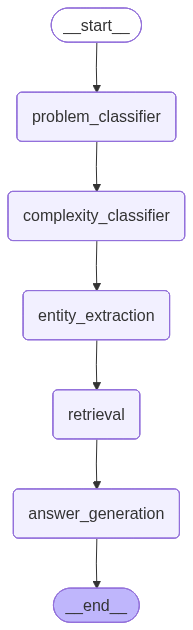


✅ Graph visualization complete!


📝 The graph above shows:
   • problem_classifier → Classifies PROBLEM_1/2/3
   • complexity_classifier → Classifies query complexity
   • entity_extraction → Extracts company & year with mapping
   • retrieval → Queries FAISS database
   • answer_generation → Generates validated answer

✅ Now you can run queries using langgraph_qa.route(query)


In [25]:
# ============================================================
# VISUALIZE THE LANGGRAPH WORKFLOW
# ============================================================

# Display the visual graph showing the complete pipeline flow
langgraph_qa.visualize_graph()

print("\n📝 The graph above shows:")
print("   • problem_classifier → Classifies PROBLEM_1/2/3")
print("   • complexity_classifier → Classifies query complexity")
print("   • entity_extraction → Extracts company & year with mapping")
print("   • retrieval → Queries FAISS database")
print("   • answer_generation → Generates validated answer")
print("\n✅ Now you can run queries using langgraph_qa.route(query)")


### 🎯 Test the LangGraph System

**Just change the query and run!**

**Examples:**
- Simple: `"What was Amazon's revenue in 2019?"`
- Reasoning: `"What percentage of revenue was in Q4 2019?"`
- Complex: `"Compare Amazon's net sales in 2019 vs 2021"`
- Real-time: `"What is the current stock price of Amazon?"`

In [26]:
# ============================================================
# LANGGRAPH TEST CELL
# ============================================================

# 🔧 PUT YOUR QUERY HERE
query = "What was Amazon's net sales in 2019?"

# Run through LangGraph pipeline
result = langgraph_qa.route(query)

# Display results
print(f"\n{'='*70}")
print("ANSWER:")
print("="*70)
print(f"{result['answer']}")

print(f"\n{'='*70}")
print("AGENT TRACE:")
print("="*70)
print(f"Method: {result['method']}")
print(f"Problem Type: {result['agent_trace']['problem_type']}")
print(f"Complexity: {result['agent_trace']['complexity']}")
print(f"Company: {result['agent_trace']['company']}")
print(f"Year: {result['agent_trace']['year']}")
print(f"Chunks Retrieved: {result['agent_trace']['retrieval_count']}")
print(f"Confidence: {result['confidence']}")

if result.get('sources'):
    print(f"\nSources:")
    for i, source in enumerate(result['sources'][:5]):
        print(f"  {i+1}. {source['company']} {source['year']}, Page {source['page']} (sim: {source['similarity']:.3f})")



🚀 RUNNING LANGGRAPH PIPELINE
Query: What was Amazon's net sales in 2019?


🔷 NODE 1: Problem Type Classification
Problem Type: PROBLEM_1
Reasoning: Single company, single year - RAG from 10-K

🔷 NODE 2: Complexity Classification
----------------------------------------------------------------------
Complexity: SIMPLE
Information Type: numerical
Requires Decomposition: False

Extracted - Company: AMZN, Year: 2019

🔷 NODE 3: Entity Extraction & Year Mapping
----------------------------------------------------------------------
Fiscal Year: 2019
Mapped to Filing Year: 2020
Final - Company: AMZN, Year: 2020

🔷 NODE 4: Retrieval (FAISS Database)
----------------------------------------------------------------------
Strategy: SIMPLE query
Top-K: 5, Embedding: NUMERICAL
🔍 Retrieval Tool Called:
   Query: What was Amazon's net sales in 2019?
   Company: AMZN, Year: 2020, Top-K: 5
   Searching NUMERICAL (financial data) index...
Retrieved 5 chunks

🔷 NODE 5: Answer Generation & Validation
----

## 🎯 Quick Test: Problem 1 (RAG - Historical 10-K Data)

**Just change your query below and run this cell!**

Examples you can try:
- `"What was Uber's total revenue in 2020?"`
- `"What were Amazon's net sales in 2019?"`
- `"How many employees did Uber have in 2021?"`

In [40]:
# ============================================================
# PROBLEM 1: RAG Query (Historical 10-K Data)
# ============================================================

# 🔧 PUT YOUR QUERY HERE (just change the text inside quotes)
# FIXED: Simplified query - the system needs clear company + year
query = "Who was Amazon's Chief Financial Officer in 2019?"

# Run the query
print("="*70)
print(f"QUERY: {query}")
print("="*70)

result = rag_agent.answer(query)

print(f"\n📝 Answer:\n{result['answer']}")
print(f"\n📚 Sources:")
for i, source in enumerate(result['sources'][:5]):
    print(f"  {i+1}. {source['company']} {source['year']}, Page {source['page']} (similarity: {source['similarity']:.3f})")

QUERY: Who was Amazon's Chief Financial Officer in 2019?
🔍 Analyzing query: Who was Amazon's Chief Financial Officer in 2019?
✨ Auto-extracted:
   Company: AMZN
   Fiscal Year: 2019
   → Searching in 2020 10-K (which contains 2019 fiscal data)
🔍 Searching for: Who was Amazon's Chief Financial Officer in 2019?
   Company: AMZN
   Year: 2020
🎯 Query classified as: TEXT
   Searching TEXT (narrative content) index...
✅ High confidence search (similarity: 0.635)
🤖 Generating answer...

📝 Answer:
According to the context, Brian T. Olsavsky was Amazon's Senior Vice President and Chief Financial Officer. This information can be found in multiple sections, including [Source 1], [Source 3], and [Source 4]. There is no mention of a change in the CFO position for 2019. Therefore, Brian T. Olsavsky was Amazon's Chief Financial Officer in 2019.

📚 Sources:
  1. AMZN 2020, Page 6 (similarity: 0.635)
  2. AMZN 2020, Page 99 (similarity: 0.608)
  3. AMZN 2020, Page 6 (similarity: 0.588)
  4. AMZN 2020,

## 🎯 Quick Test: Problem 2 (Multi-Company/Multi-Year Comparison)

**Just change your query below and run this cell!**

Examples you can try:
- `"Compare Amazon's net sales in 2019 vs 2021"`
- `"Summarize the major risk factors in Uber 2021 and Amazon 2020"`

In [41]:
# ============================================================
# PROBLEM 2: Multi-Company/Multi-Year Comparison
# ============================================================

# 🔧 PUT YOUR QUERY HERE
query = "How did Uber's research and development expenses change from 2019 to 2021? Show the trend."

# Run the comparative query
print("="*70)
print(f"QUERY: {query}")
print("="*70)

# Decompose the complex query
sub_queries = decomposer.decompose(query)

print(f"\n🔧 Decomposed into {len(sub_queries)} sub-queries:")
for i, sq in enumerate(sub_queries):
    print(f"  {i+1}. {sq}")

# Get the comparative answer
result = rag_agent.answer_comparative(sub_queries)

print(f"\n📝 Comparative Answer:\n{result['answer']}")
print(f"\n📚 Sources used:")
for i, source in enumerate(set([(s['company'], s['year']) for s in result['sources']])):
    print(f"  {i+1}. {source[0]} {source[1]}")


QUERY: How did Uber's research and development expenses change from 2019 to 2021? Show the trend.
🔧 Decomposing query: How did Uber's research and development expenses change from 2019 to 2021? Show the trend.
   Generated 3 sub-queries
   - {'query': "What were Uber's research and development expenses?", 'company': 'UBER', 'year': 2019}
   - {'query': "What were Uber's research and development expenses?", 'company': 'UBER', 'year': 2020}
   - {'query': "What were Uber's research and development expenses?", 'company': 'UBER', 'year': 2021}

🔧 Decomposed into 3 sub-queries:
  1. {'query': "What were Uber's research and development expenses?", 'company': 'UBER', 'year': 2019}
  2. {'query': "What were Uber's research and development expenses?", 'company': 'UBER', 'year': 2020}
  3. {'query': "What were Uber's research and development expenses?", 'company': 'UBER', 'year': 2021}
🔍 Answering comparative query with 3 sub-queries
🔍 Searching for: What were Uber's research and development exp

## 🎯 Quick Test: Problem 3 (Real-Time Stock Prices)

**Just change your query below and run this cell!**

Examples you can try:
- `"What is the current stock price of Amazon?"`
- `"What are the current stock prices of Amazon and Uber?"`
- `"Extract stock prices of Uber for the last 7 days"`

In [44]:
# ============================================================
# PROBLEM 3: Real-Time Stock Price (via RapidAPI)
# ============================================================

# 🔧 PUT YOUR QUERY HERE
query = "What is the current stock price of Amazon and Uber?"

# Run the query
print("="*70)
print(f"QUERY: {query}")
print("="*70)

result = api_agent.answer(query)

print(f"\n📝 Answer:\n{result['answer']}")

if result.get('data'):
    print("\n💰 Raw Data:")
    for symbol, data in result['data'].items():
        print(f"\n{symbol}:")
        print(f"  Current Price: ${data['currentPrice']}")
        if data.get('revenue'):
            print(f"  Revenue: ${data['revenue']:,.0f}")
else:
    print("\n⚠️ Could not fetch stock data. Check your RAPIDAPI_KEY in .env")


QUERY: What is the current stock price of Amazon and Uber?
📈 Fetching real-time stock data for query: What is the current stock price of Amazon and Uber?
   Identified symbols: ['AMZN', 'UBER']

📝 Answer:
The current stock prices are:

* Amazon (AMZN): **$247.38**
* Uber (UBER): **$85.44**

💰 Raw Data:

AMZN:
  Current Price: $247.38
  Revenue: $691,330,023,424

UBER:
  Current Price: $85.44
  Revenue: $49,609,998,336


---

## 🎉 Done!

You can now test any query by:
1. Editing the `query = "..."` line in any of the 3 cells above
2. Running that cell

**Happy Testing! 🚀**